---
title: 'Replication Study: Racial Bias in Health Algorithms'
author: 'Andre Xiao'
date: '2024-03-07'
image: 'doctor.jpg'
description: 'A replication study of "Dissecting racial bias in an algorithm used to manage the health of populations" by Ziad Obermeyer, Brian Powers, Christine Vogeli, and Sendhil Mullainathan.'
format: html
code-annotations: hover
---

![Image source: berkeley.edu](https://s3.amazonaws.com/cms.ipressroom.com/401/files/202306/Doctor.jpg)

## Abstract

This replication study is based on the journal article ["Dissecting racial bias in an algorithm used to manage the health of populations"](https://www.science.org/doi/full/10.1126/science.aax2342).

> Obermeyer, Ziad, Brian Powers, Christine Vogeli, and Sendhil Mullainathan. 2019. “Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations.” Science 366 (6464): 447–53.

The article analyzes the racial bias caused by healthcare algorithms that predict healthcare costs instead of illness. In the health system studied by the article, patients with risk scores above the 97th percentile are admitted into the care management program while those in the 55th percentile are referred to their primary care physician who are asked to consider whether the patient would benefit from the program. For equal risk scores, Blacks typically have a higher number of illnesses than Whites. This results in Blacks being less likely to be admitted to the care management program than Whites are. However, it also finds that because these algorithms target patients with high costs, the results are inconsistent by algorithmic bias, such as calibration. That is, across the entire risk distribution, predictions of cost are unbiased towards Whites or Blacks by risk score. This study aimed to replicate these findings through Figure 1 and 3 from the article and calculate the cost disparity shown in Figure 3 using linear regression. After replicating the figures and calculating the cost disparity, this study confirmed the findings of the article. At similar risk scores, Blacks typically are typically more ill than Whites and conditional on risk score, there is no significant difference between predicted costs.

## Overview of the Data

The authors did not share the "real" data to protect patient privacy. Instead, the data contains attributes for each patient with randomized data that preserves many of the same patterns and trends. More information on the data can be found [here](https://gitlab.com/labsysmed/dissecting-bias/-/blob/master/data/data_dictionary.md). The attributes used in this replication study are:

- `risk_score_t`: the patient's risk assigned by the algorithm
- `cost_t`: the patient’s total medical expenditure during the study period
- `race`: the patient’s self-reported race (`white` or `black`)
- `gagne_sum_t`: the patient's total number of active chronic illnesses during the study period
- `dem_female`: whether a patient is female (`1`) or not (`0`)

In [1]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


## Reproducing Figure 1

Figure 1 in the article depicts the relationship between the mean number of chronic illnesses and the percentiles of risk scores for patients divided by race and gender. To reproduce Figure 1, each `risk_score_t` must be converted into its percentile value. The percentiles are stored in the column `risk_percentile`.

In [2]:
from scipy import stats

df['risk_percentile'] = stats.percentileofscore(df['risk_score_t'], df['risk_score_t'], kind = 'rank').round(decimals = 0) # <1>

1. Gets the percentile for each `risk_score_t` by `kind = 'rank'` and rounds it to the nearest integer.

Here's what the percentiles of risk scores look like compared to the actual risk scores.

In [3]:
df[['risk_score_t', 'risk_percentile']].head()

,risk_score_t,risk_percentile
0,1.987430,35.0
1,7.677934,86.0
2,0.407678,4.0
3,0.798369,11.0
4,17.513165,98.0


Below is the replication of Figure 1.

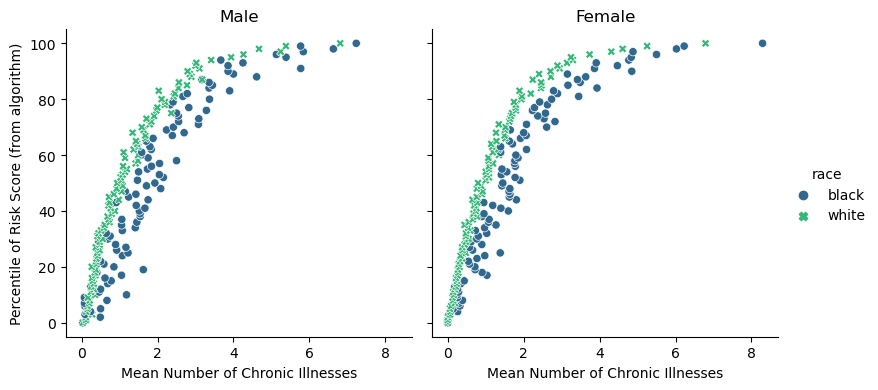

In [4]:
#| code-fold: true
#| label: fig-risk-ill
#| fig-cap: 'Risk percentile by mean number of chronic illnesses by race and gender.'
#| fig-subcap:
#|  - 'Male patients' 
#|  - 'Female patients'

import seaborn as sns
import matplotlib.pyplot as plt

risk_ill = df.groupby(['risk_percentile', 'race', 'dem_female'], observed = False).agg({'gagne_sum_t':'mean'}) # <1>

risk_ill_plt = sns.relplot(data=risk_ill, # <2>
                           col='dem_female', # <2>
                           col_wrap=2, # <2>
                           x = 'gagne_sum_t', # <2>
                           y = 'risk_percentile', # <2>
                           hue = 'race', # <2>
                           style = 'race', # <2>
                           kind='scatter', # <2>
                           height=4, # <2>
                           palette = 'viridis') # <2>

risk_ill_plt.set(xlabel = 'Mean Number of Chronic Illnesses',
                 ylabel = 'Percentile of Risk Score (from algorithm)',
                 xticks = [0, 2, 4, 6, 8],
                 yticks = [0, 20, 40, 60, 80, 100],)

risk_ill_plt.axes[0].set(title = 'Male')
risk_ill_plt.axes[1].set(title = 'Female');

1. Calculates the mean number of chronic illnesses for a patient grouped by their risk score percentile, race, and gender.
2. Plots the relationship between the mean number of chronic illnesses and risk score percentile.

As seen in @fig-risk-ill of this study, for a given mean number of chronic illnesses, Blacks are typically given a much lower risk score than Whites are. As a result, they will be much less likely to be referred to the high-risk care management program than Whites will. This corroborates the findings of the article.

## Reproducing Figure 3

Figure 3 from the article depicts the the total expenditure for patients given their percentile of risk scores and total number of chronic illnesses. Below is the replication of Figure 3.

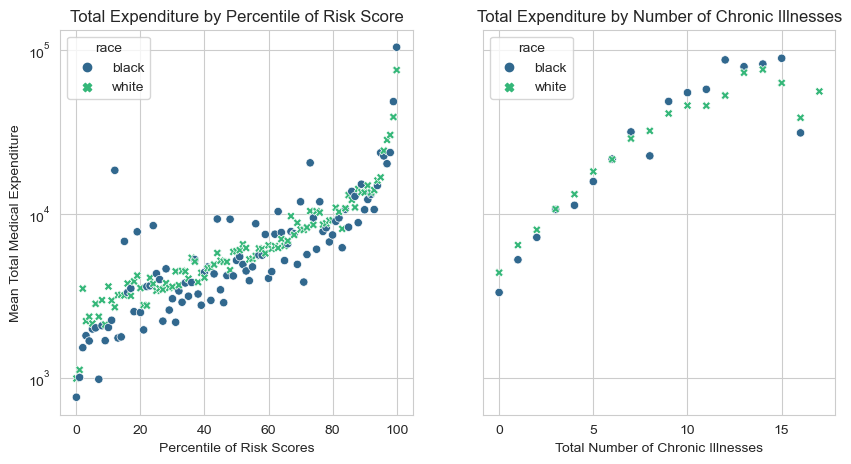

In [5]:
#| code-fold: true
#| label: fig-risk-ill-cost
#| fig-cap: 'Replication of Figure 3 from the article.'

risk_cost = df.groupby(['risk_percentile', 'race'], observed = False).agg({'cost_t':'mean'}) # <1>

sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2, figsize = (10, 5), sharey = True)

risk_cost_plt = sns.scatterplot(risk_cost, # <2>
                               x = 'risk_percentile', # <2>
                               y = 'cost_t', # <2>
                               hue = 'race', # <2>
                               style = 'race',  # <2>
                               palette = 'viridis', # <2>
                               ax = ax[0]) # <2>

risk_cost_plt.set(xlabel = 'Percentile of Risk Scores',
                 ylabel = 'Mean Total Medical Expenditure',
                 xticks = [0, 20, 40, 60, 80, 100],
                 title = 'Total Expenditure by Percentile of Risk Score');

ax[0].set_yscale('log') # <3>

ill_cost = df.groupby(['gagne_sum_t', 'race'], observed = False).agg({'cost_t':'mean'}).reset_index() # <4>

ill_cost_plt = sns.scatterplot(ill_cost, # <5>
                               x = 'gagne_sum_t', # <5>
                               y = 'cost_t', # <5>
                               hue = 'race', # <5>
                               style = 'race', # <5>
                               palette = 'viridis', # <5>
                               ax = ax[1]) # <5>

ill_cost_plt.set(xticks = [0, 5, 10, 15])

ill_cost_plt.set(xlabel = 'Total Number of Chronic Illnesses',
                 title = 'Total Expenditure by Number of Chronic Illnesses');

1. Calculates the mean total cost of patients grouped by risk score percentile and race.
2. Plots the mean total cost of patients by risk score percentile.
3. Sets the y-axis to be of logarithmic scale.
4. Calculates the mean total cost of patients grouped by the total number of chronic illnesses and race.
5. Plots the mean total cost of patients by total number of chronic illnesses.

Looking at @fig-risk-ill-cost from this study, we can see that both Blacks and Whites have similar total costs by both the percentile of risk scores and the total number of chronic illnesses. Additionally, it's also important to note that most patients have five or fewer chronic illnesses, so looking at @fig-risk-ill-cost, we can see that Blacks actually generate lower costs than Whites for patients with fewer than five chronic illnesses. In fact, the article states that Blacks generate on average about $1801 less per year in costs which @fig-risk-ill seems to support.

## Modeling Cost Disparity
Building on the findings from @fig-risk-ill, I attempt to quantify the disparity in cost for patients with five or fewer chronic illnesses. The reason for only looking at patients with five or fewer chronic illnesses, as stated above, is because there are much fewer patients with more than five chronic illnesses. To model the mean total expenditure for patients with five or fewer chronic illnesses, I use polynomial linear regression to predict the logarithm of the costs then extract the coefficient, $w_b$, given to Blacks. In the context of a log-transformed linear model, $e^{w_b}$ is an estimate for the percentage of cost generated by Blacks compared to a Whites with an equal number of chronic illnesses. Additionally, the reason for a polynomial linear regression model is to account for nonlinearity.

To confirm the claim that most patients have five or fewer chronic illnesses, here is the percentage of patients with five or fewer chronic illnesses.

In [6]:
(df['gagne_sum_t'] <= 5).mean() * 100 # <1>

95.53952115447689

1. Calculates the percentage of patients with five or fewer chronic illnesses.

Indeed, more than 95% of the patients have five or fewer chronic illnesses. Next, I extract the patients with five or fewer and non-zero expenditure and calculate the logarithm of the costs. The reason for only extracting patients with non-zero expenditure is because $\log{(0)}$ is undefined.

In [7]:
df_train = df[(df['gagne_sum_t'] <= 5) & (df['cost_t'] != 0)] # <1>

import numpy as np

df_train['log_cost_t'] = np.log(df_train['cost_t']) # <2>

1. Extracts all patients with five or fewer illnesses and non-zero expenditure into a new dataframe, `df_train`.
2. Creates new column, `log_cost_t`, that is the logarithm of the costs.

Then, I split the data into the target variable `log_cost_t` and the predictor variables `gagne_sum_t`, and `race`. I then one-hot encode `race` for linear regression.

In [8]:
y_train = df_train['log_cost_t'] # <1>
X_train = df_train.drop(['log_cost_t'], axis = 1) # <2>
X_train = X_train[['gagne_sum_t', 'race']] # <3>
X_train = pd.get_dummies(X_train, columns=['race']) # <4>

X_train.head()

,gagne_sum_t,race_black,race_white
0,0,False,True
1,3,False,True
2,0,False,True
3,0,False,True
4,1,False,True


1. Set $y$ data to `log_cost_t`.
2. Drops `log_cost_t` from $x$ data.
3. Get only `gagne_sum_t` and `race` for $x$ data.
4. One-hot encodes `race`.

Below is a function that constructs new columns for polynomials of various degrees.

In [29]:
def add_polynomial_features(X, degree): # <1>
  X_ = X.copy()# <1>

  for j in range(2, degree): # <1>
    X_[f'poly_{j}'] = X_['gagne_sum_t']**j # <1>
  return X_ # <1>

1. Creates a new columns $\text{poly\_}2 = \text{(gagne\_sum\_t)}^2,... , \text{poly\_}j = \text{(gagne\_sum\_t)}^j $.

Next, I use cross validation to find the best degree polynomial for the linear regression model.

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

LR = LinearRegression() # <1>

degree = np.arange(1, 21) # <2>
cross_score = np.zeros(len(degree)) # <3>

for i in degree: # <4>
    X = add_polynomial_features(X_train, i) # <4>
    cross_score[i-1] = cross_val_score(LR, X, y_train, cv = 5).mean() # <4>

1. Initializes linear regression instance.
2. Vector to of degrees to test.
3. Vector of zeroes to store the mean cross validation scores.
4. Tests all degrees in and stores the mean cross validation scores in `cross_score`. Uses five-fold cross validation.

After, I get the degree (`14`) with the best score for use in the linear regression model.

In [31]:
best_i = np.argmax(cross_score) # <1>
best_d = degree[best_i] # <2>
best_d

14

1. Gets index of best mean cross validation score.
2. Gets the degree with best mean cross validation score.

Now, I train the linear regression model using the best degree polynomial and calculate the estimated percentage of cost disparity between Blacks and Whites with the same number of chronic illnesses.

In [33]:
X = add_polynomial_features(X_train, best_d) # <1>
LR.fit(X, y_train) # <2>
score = LR.score(X, y_train) # <2>
w = LR.coef_ # <3>
np.exp(w[1]) # <4>

0.8680649776385329

1. Set `X` to be dataset with the 14 degree polynomial of `gagne_sum_t`.
2. Train `X` using linear regression and retrieve the score.
3. Get the coefficients of the trained model and store it in `w`.
4. Calculates the estimated percentage of cost disparity between Blacks and Whites with the same number of chronic illnesses ($e^{w[1]}$ where $w[1] = w_b$)

As we can see, Blacks generate an estimated 86.8% the cost of Whites. This roughly confirms the findings from the article that Blacks generate less costs than Whites.

## Discussion

For similar risk scores and number of illnesses, Blacks and Whites generate similar costs (@fig-risk-ill). In fact, Blacks generate an estimated 87% less cost than Whites. However, when comparing Blacks and Whites by their risk score based on their chronic number of illnesses, Blacks have a much lower risk score per number of illnesses (@fig-risk-ill). As a result, they are less likely to be accepted into the system's care management program. Though the study meets the calibration criterion for fairness, it violates the independence criterion for fairness as Blacks have a lower acceptance rate into the system's care managemet program than Whites. This could present a problem, since most industry-wide algorithms predict cost leading to bias against Blacks. This results in a system wide case of Blacks being unable to receive the healthcare they need, which in turn reduces their medical expenditures. To fix this bias, the authors of the article used an index variable which combined cost and health prediction, reducing the bias by 87%. The hope is that by showing that label bias is fixable other manufacturers will be prompted to make similar fixes, minimizing the risks of algorithmic predictions while still benefitting from them.